In [14]:
import os
import json

import numpy as np 

import matplotlib as mpl
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'grid'])
mpl.rcParams["font.size"] = "16"

In [15]:
with open('./data/evaluation.json', 'r') as f:
    results = json.loads(f.read())
    
models = results.keys()

In [16]:
models

dict_keys(['default_10_64', 'default_10_48', 'default_10_32', 'default_10_24', 'random_10_64', 'random_10_48', 'random_10_32', 'random_10_24'])

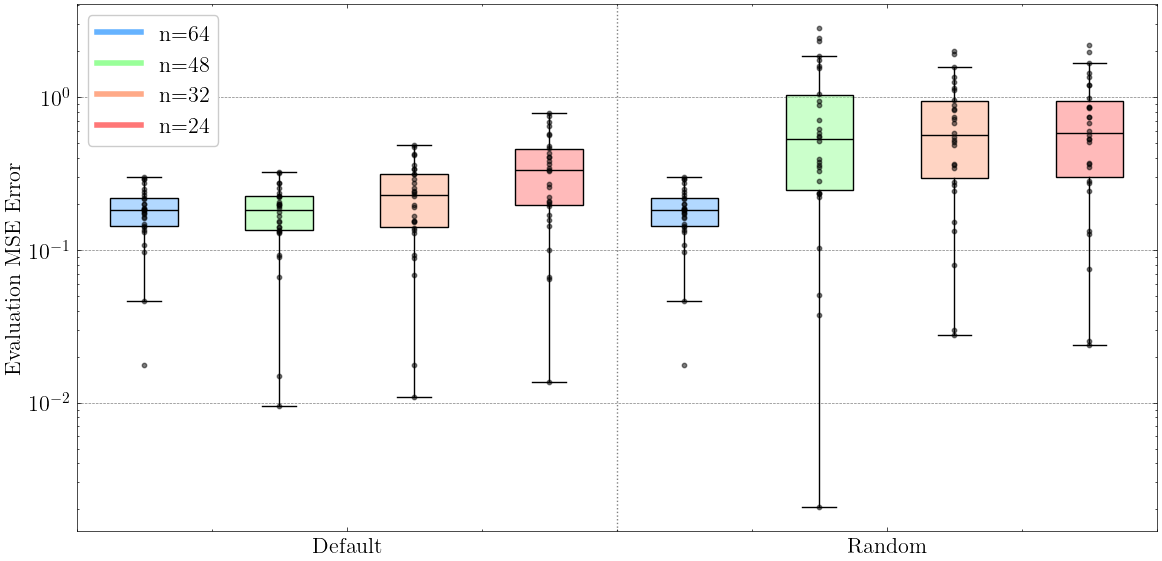

In [17]:
# Prepare data for boxplot
boxplot_data = []
labels = []

models = ['default', 'random']
ns = [64, 48, 32, 24]

for model in models:
    for n in ns:
        key = f"{model}_10_{n}"
        boxplot_data.append(results[key])
        labels.append(key)

# Create the boxplot
plt.figure(figsize=(12, 6))
box = plt.boxplot(boxplot_data, patch_artist=True, notch=False, vert=True, zorder=1, showfliers=False)

# Define colors for the boxplots
colors = ['#FF7777', '#FFAA88', '#99FF99', '#66B3FF'][::-1]
for i, patch in enumerate(box['boxes']):
    model_index = i // len(ns)  # Determine the model index
    # patch.set_alpha(0.5)
    patch.set_edgecolor('black')
    patch.set_facecolor(colors[i % len(colors)])  # Set color based on hyperparameter
    
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.5))
    
    data = boxplot_data[i]
    y = np.random.normal(i + 1, 0.0, size=len(data))
    plt.scatter(y, data, alpha = 0.5, color = 'black', s = 10, zorder = 2)
    
for median in box['medians']:
    median.set_color('black')

# Adding legend
handles = [plt.Line2D([0], [0], color=colors[i], lw=4) for i in range(len(ns))]
labels_legend = [f'n={n}' for n in ns]
plt.legend(handles, labels_legend, loc='upper left', ncol=1)

# Set x-ticks and labels
plt.xticks([2.5, 6.5], ['Default', 'Random'], rotation = 0)
plt.ylabel('Evaluation MSE Error')
plt.grid(False, axis='x')

plt.axvline(4.5, 0, alpha = 0.5, color = 'black', linestyle = ':')

plt.yscale('log')

# Show the plot
plt.tight_layout()
plt.savefig('./performance 1.svg')
plt.show()

In [18]:
def load_data(run_name):
    with open(f'./data/{run_name}.json', 'r') as file:
        result = json.loads(file.read())
    return result

def get_plotting_data(key, *names):
    result = []
    for name in names:
        result.append(load_data(name)[key])
    result = np.array(result)
    
    mean = result.mean(axis=0)
    var = result.std(axis=0)
    
    return mean, var

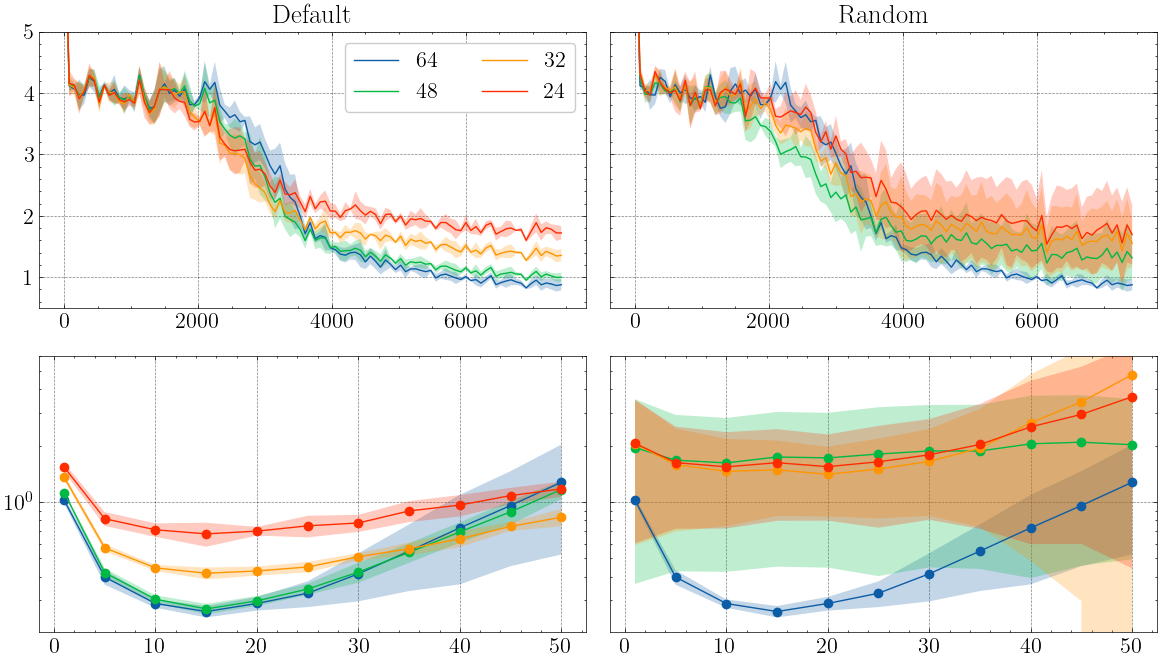

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(12, 7), sharey='row')

x = np.arange(0, 7500, 75)

groups = []
for model in models:
    for n in ns:
        group = []
        for seed in [42, 451, 1984]:
            group.append(f'{model}_10_{n}_{seed}')
        groups.append(group)

bs = [1] + list(range(5, 51, 5))
for group, model in zip(groups[:4], ns):
    mean, var = get_plotting_data('loss', *group)
    mean = mean[::75]
    var = var[::75]
    axs[0][0].plot(x, mean, label = model, linewidth = 1)
    axs[0][0].fill_between(x, mean + var, mean - var, alpha = 0.25, linewidth = 0)
    
    mean, var = get_plotting_data('extr', *group)
    axs[1][0].plot(bs, mean, label = model, linewidth = 1, marker = 'o')
    axs[1][0].fill_between(bs, mean + var, mean - var, alpha = 0.25, linewidth = 0)
    
for group, model in zip(groups[4:], ns):
    mean, var = get_plotting_data('loss', *group)
    mean = mean[::75]
    var = var[::75]
    axs[0][1].plot(x, mean, label = model, linewidth = 1)
    axs[0][1].fill_between(x, mean + var, mean - var, alpha = 0.25, linewidth = 0)
    
    mean, var = get_plotting_data('extr', *group)
    axs[1][1].plot(bs, mean, label = model, linewidth = 1, marker = 'o')
    axs[1][1].fill_between(bs, mean + var, mean - var, alpha = 0.25, linewidth = 0)

for i in range(2):
    axs[0][i].set_ylim(bottom = 0.5, top = 5)
    axs[1][i].set_yscale('log')
    axs[1][i].set_ylim(top = 6)
    
axs[0][0].title.set_text('Default')
axs[0][1].title.set_text('Random')
axs[0][0].legend(loc = 'upper right', ncols = 2)
    
plt.tight_layout()
plt.savefig('./loss comparison.svg')
plt.show()

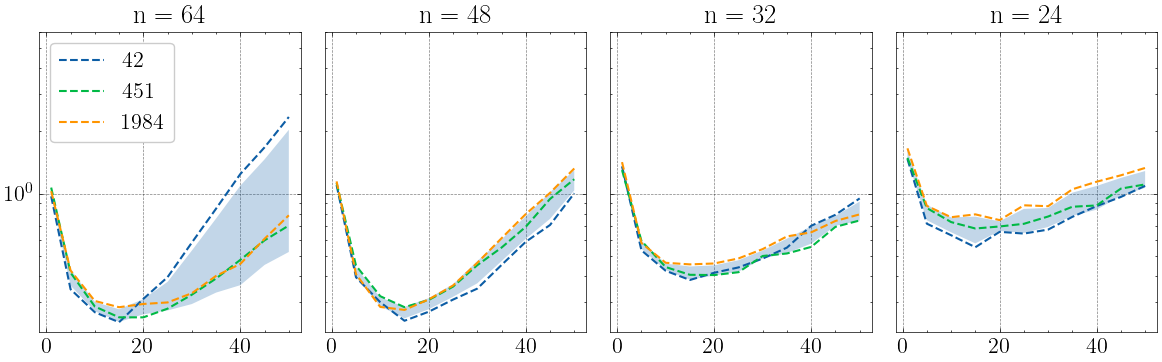

In [35]:
fig, axs = plt.subplots(1, 4, figsize=(12, 4), sharey=True)

x = np.arange(0, 7500, 75)

groups = []
ns = [64, 48, 32, 24]
for model in ['default']:
    for n in ns:
        group = []
        for seed in [42, 451, 1984]:
            group.append(f'{model}_10_{n}_{seed}')
        groups.append(group)

bs = [1] + list(range(5, 51, 5))
for i, (group, model) in enumerate(zip(groups, ns)):
    
    for seed in [42, 451, 1984]:
        data = load_data(f'default_10_{model}_{seed}')['extr']
        axs[i].plot(bs, data, label = seed, linewidth = 1.5, linestyle = '--')
    
    mean, var = get_plotting_data('extr', *group)
    axs[i].fill_between(bs, mean + var, mean - var, alpha = 0.25, linewidth = 0)

for i in range(4):
    axs[i].set_yscale('log')
    axs[i].set_ylim(top = 6)
    
axs[0].title.set_text('n = 64')
axs[1].title.set_text('n = 48')
axs[2].title.set_text('n = 32')
axs[3].title.set_text('n = 24')

# colors = [axs[0].get_lines()[i].get_color() for i in range(4)]

# handles = [plt.Line2D([0], [0], color=colors[i], linestyle='--', lw=2) for i in range(3)]
# handles += [plt.Line2D([0], [0], color=colors[-1], lw=2)]

# labels_legend = [42, 451, 1984] + ['Mean']
# for i in range(4):
#     axs[i].legend([handles[i]], [labels_legend[i]], loc = 'upper center', ncols = 1)

axs[0].legend(loc = 'upper left')
plt.tight_layout()
plt.savefig('./extrap comparison.svg')
plt.show()